In [84]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
import numpy as np
import mne
import xarray as xr
import matplotlib.pyplot as plt
from scipy import signal
import ghibtools as gh
import pandas as pd
import seaborn as sns
import neurokit2 as nk
from params import *
from bibliotheque import *
import physio
import time
from compute_phase_freq import baseline_power_job, phase_freq_job

In [86]:
run_key = 'P04_baseline'

In [87]:
baseline = baseline_power_job.get(run_key)['baseline']

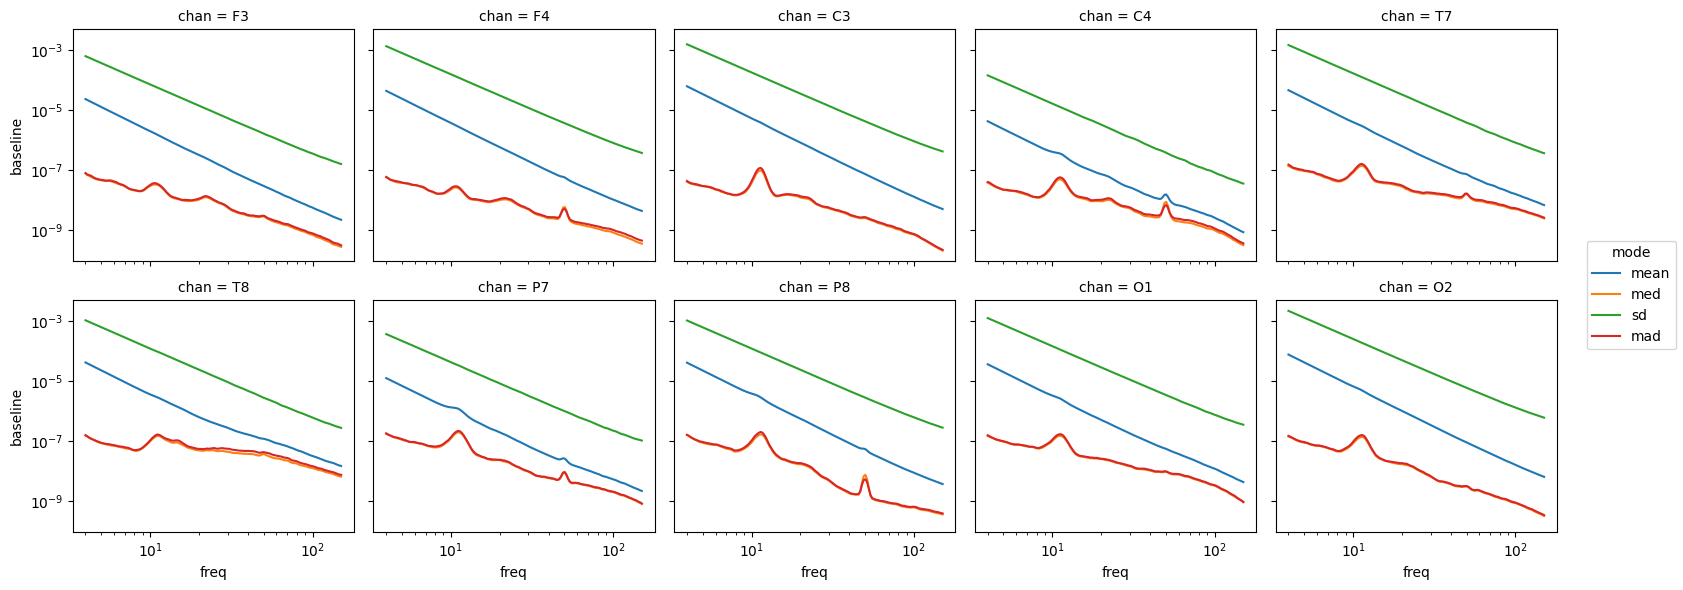

In [89]:
baseline.plot.line(x = 'freq', yscale ='log', xscale = 'log', col = 'chan', col_wrap = 5)

In [75]:
run_key = 'P04_odor'

In [76]:
phase_freq = phase_freq_job.get(run_key)

In [77]:
phase_freq

<xarray.Dataset>
Dimensions:              (phase: 200, freq: 150, chan: 10,
                          compress_cycle_mode: 3, baseline_mode: 2)
Coordinates:
  * phase                (phase) float64 0.0 0.005025 0.01005 ... 0.995 1.0
  * freq                 (freq) float64 4.0 4.098 4.199 ... 142.9 146.4 150.0
  * chan                 (chan) object 'F3' 'F4' 'C3' 'C4' ... 'P8' 'O1' 'O2'
  * compress_cycle_mode  (compress_cycle_mode) object 'mean_cycle' ... 'q75_c...
  * baseline_mode        (baseline_mode) object 'z_score' 'rz_score'
Data variables:
    itpc                 (chan, freq, phase) float64 ...
    power                (baseline_mode, compress_cycle_mode, chan, freq, phase) float64 ...

In [78]:
power = phase_freq['power']

In [91]:
power

<xarray.DataArray 'power' (baseline_mode: 2, compress_cycle_mode: 3, chan: 10,
                           freq: 150, phase: 200)>
[1800000 values with dtype=float64]
Coordinates:
  * phase                (phase) float64 0.0 0.005025 0.01005 ... 0.995 1.0
  * freq                 (freq) float64 4.0 4.098 4.199 ... 142.9 146.4 150.0
  * chan                 (chan) object 'F3' 'F4' 'C3' 'C4' ... 'P8' 'O1' 'O2'
  * compress_cycle_mode  (compress_cycle_mode) object 'mean_cycle' ... 'q75_c...
  * baseline_mode        (baseline_mode) object 'z_score' 'rz_score'

In [79]:
itpc = phase_freq['itpc']

In [90]:
itpc

<xarray.DataArray 'itpc' (chan: 10, freq: 150, phase: 200)>
[300000 values with dtype=float64]
Coordinates:
  * phase    (phase) float64 0.0 0.005025 0.01005 0.01508 ... 0.9899 0.995 1.0
  * freq     (freq) float64 4.0 4.098 4.199 4.303 ... 139.4 142.9 146.4 150.0
  * chan     (chan) object 'F3' 'F4' 'C3' 'C4' 'T7' 'T8' 'P7' 'P8' 'O1' 'O2'

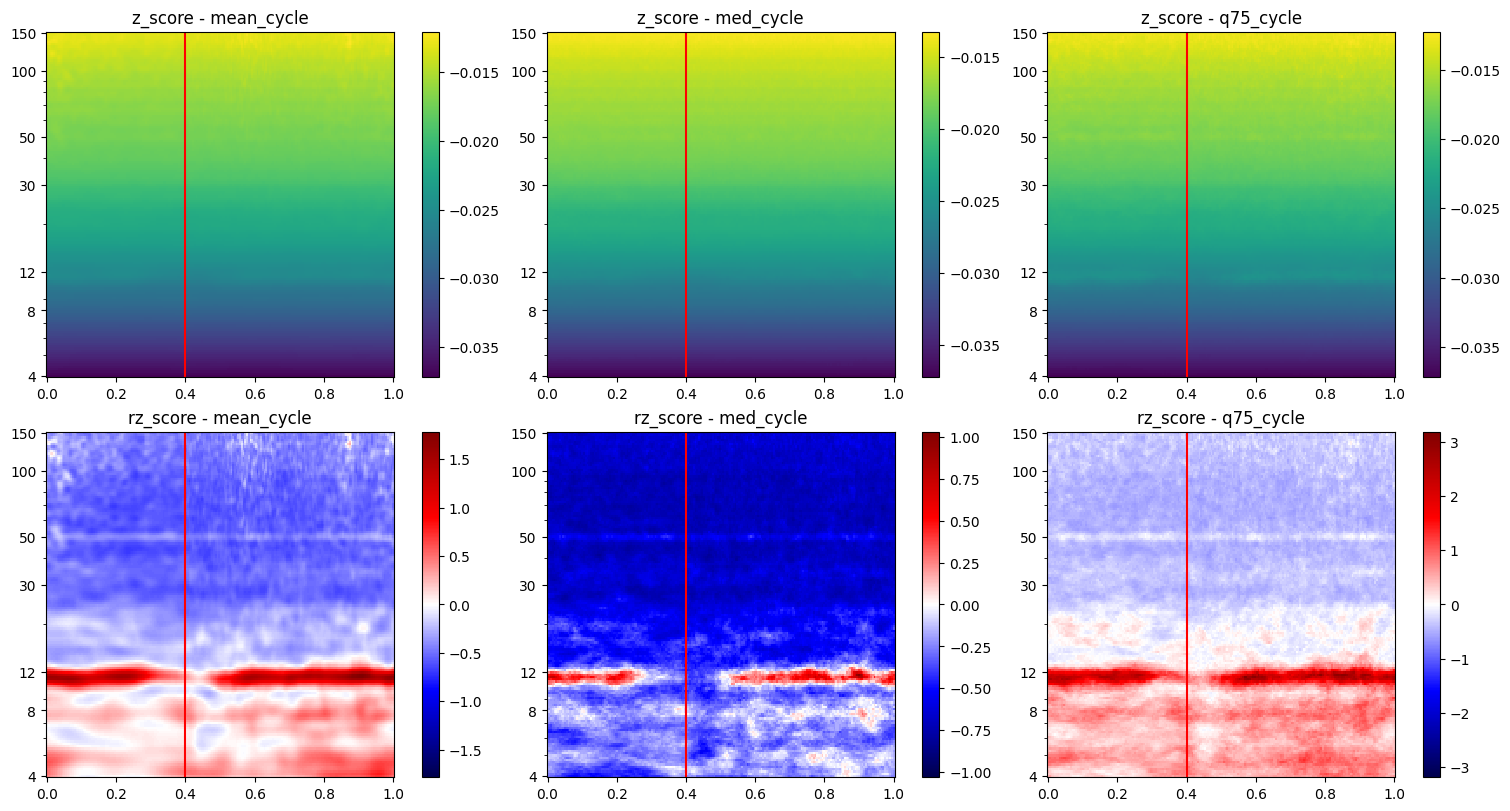

In [80]:
delta = 0.

nrows = power.coords['baseline_mode'].size
ncols = power.coords['compress_cycle_mode'].size

freq_ticks = [4 , 8 , 12 , 30 , 50 , 100 , 150]

fig, axs = plt.subplots(nrows, ncols , figsize = (15,8), constrained_layout = True)

for r,  baseline_mode in enumerate(power.coords['baseline_mode'].values):
    for c, compress_cycle_mode in enumerate(power.coords['compress_cycle_mode'].values):
        ax = axs[r,c]
        
        tf = power.loc[baseline_mode,compress_cycle_mode, 'F3', :, :].values
        
        vmin = np.quantile(tf, q = delta)
        vmax = np.quantile(tf, q = 1 - delta)
        
        
        if vmax > 0 and vmin < 0:
            vmin = vmin if abs(vmin) > abs(vmax) else -vmax 
            vmax = vmax if abs(vmax) > abs(vmin) else abs(vmin)
            cmap = 'seismic'
        else:
            vmin = vmin
            vmax = vmax
            cmap = 'viridis'
        
        im = ax.pcolormesh(
            power.coords['phase'].values,
            power.coords['freq'].values,
            tf,
            cmap = cmap,
            vmin=vmin,
            vmax=vmax)
        
        ax.set_yscale('log')
        ax.set_yticks(freq_ticks, labels = freq_ticks)
        ax.set_title(f'{baseline_mode} - {compress_cycle_mode}')
        ax.axvline(0.4, color ='r')
        
        fig.colorbar(im ,ax=ax)
        
    